In [1]:
## import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner, plot_timeseries, scale_timeseries_data, \
filter_invalid_stocks, GenericModelRunner, GenericDataloader
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


import torch
from torch import nn as nn
from torch.nn import functional as F

from transformer_common import GeluFeedForward, TransformerConfig, \
    PositionalEmbedding, DistancePositionalEmbedding, AbstractModel, RMSNorm,LinearFeedForward


class Block(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.l_norm1 = RMSNorm(config.n_embed)
        self.attention = attention_provider()
        self.l_norm2 = RMSNorm(config.n_embed)
        self.ffwd = GeluFeedForward(config.n_embed, config.hidden_size, config.n_embed, config.dropout, bias=False)

    def forward(self, x):
        x = x + self.attention(self.l_norm1(x))
        x = x + self.ffwd.forward(self.l_norm2(x))
        return x

class BlockSequence(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.blocks = nn.Sequential(*[Block(config, attention_provider) for _ in range(config.n_layer)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    
class TorchMultiHeadAttention(nn.Module):
    # https: // pytorch.org / docs / stable / generated / torch.nn.functional.scaled_dot_product_attention.html
    def __init__(self, config):
        super().__init__()

        num_heads = config.n_head
        embed_dimension = config.n_embed
        is_causal = config.causal
        dropout = config.dropout
        bias = False

        assert embed_dimension % num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(embed_dimension, 3 * embed_dimension, bias=bias)
        # output projection
        self.c_proj = nn.Linear(embed_dimension, embed_dimension, bias=bias)
        # regularization
        self.dropout = dropout
        self.resid_dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.embed_dimension = embed_dimension
        # Perform causal masking
        self.is_causal = is_causal

    def forward(self, x):
    
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        query_projected = self.c_attn(x)

        batch_size = query_projected.size(0)
        embed_dim = query_projected.size(2)
        head_dim = embed_dim // (self.num_heads * 3)

        query, key, value = query_projected.chunk(3, -1)
        query = query.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # Apply attention with modified scores
        if self.training:
            dropout = self.dropout
            is_causal = self.is_causal
        else:
            dropout = 0.0
            is_causal = False

        y = F.scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=dropout,
                                           is_causal=is_causal)

        y = y.transpose(1, 2).view(batch_size, -1, self.num_heads * head_dim)

        y = self.resid_dropout(self.c_proj(y))
        return y


class TorchTransformerModel(AbstractModel):
    def __init__(self, config):
        super().__init__(config)
        # self.pos_emb1 = PositionalEmbedding(config)
        self.ffwd1 = GeluFeedForward(config.input_embed, config.hidden_size, config.n_embed, config.dropout, bias=True)
        self.t1 = BlockSequence(config, lambda: TorchMultiHeadAttention(config))
        self.ffwd2 = GeluFeedForward(config.n_embed, config.hidden_size, config.output_embed, config.dropout, bias=True)

    def forward(self, inp):
        x = inp
        b, t, c = x.shape
        x = self.ffwd1(x)
        # pos_emb = self.pos_emb1(b, t)
        x = self.t1(x)
        x = self.ffwd2(x)
        return x



False


In [2]:
import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
from transformer_common import TimeseriesDataloader

my_device = 'mps'

# Start the timer
start_time = time.time()

input_tensor_file = 'stock_history_data.pt'

if os.path.exists(input_tensor_file):
    data = torch.load(input_tensor_file)
    ln = len(data)
    print(f"Tensor loaded successfully: {input_tensor_file}, len={ln}")
else:
    directory_path = './us-stock-dataset/Data/StockHistory'

    all_files = [os.path.splitext(f)[0] for f in os.listdir(directory_path) if f.endswith('.csv')]
    
    stocks_to_load = set(all_files)
    dataloader = TimeseriesDataloader(directory_path, stocks_to_load, add_diff=False)
    
    data=dataloader.get_data().transpose(0, 1).cuda()

    torch.save(data, input_tensor_file)

    print(f"Tensor saved successfully: {input_tensor_file}")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")
# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


False
Tensor loaded successfully: stock_history_data.pt, len=6262
Execution time: 0.0215 seconds


/var/folders/3l/9k1jwyrx3nnfw4578m3876ww0000gn/T/ipykernel_64811/3072982693.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(input_tensor_file)


In [3]:
print(data.shape)

data = filter_invalid_stocks(data)
print(f"shape after filtering {data.shape}" )

torch.Size([6262, 5283])
shape after filtering torch.Size([4735, 5283])


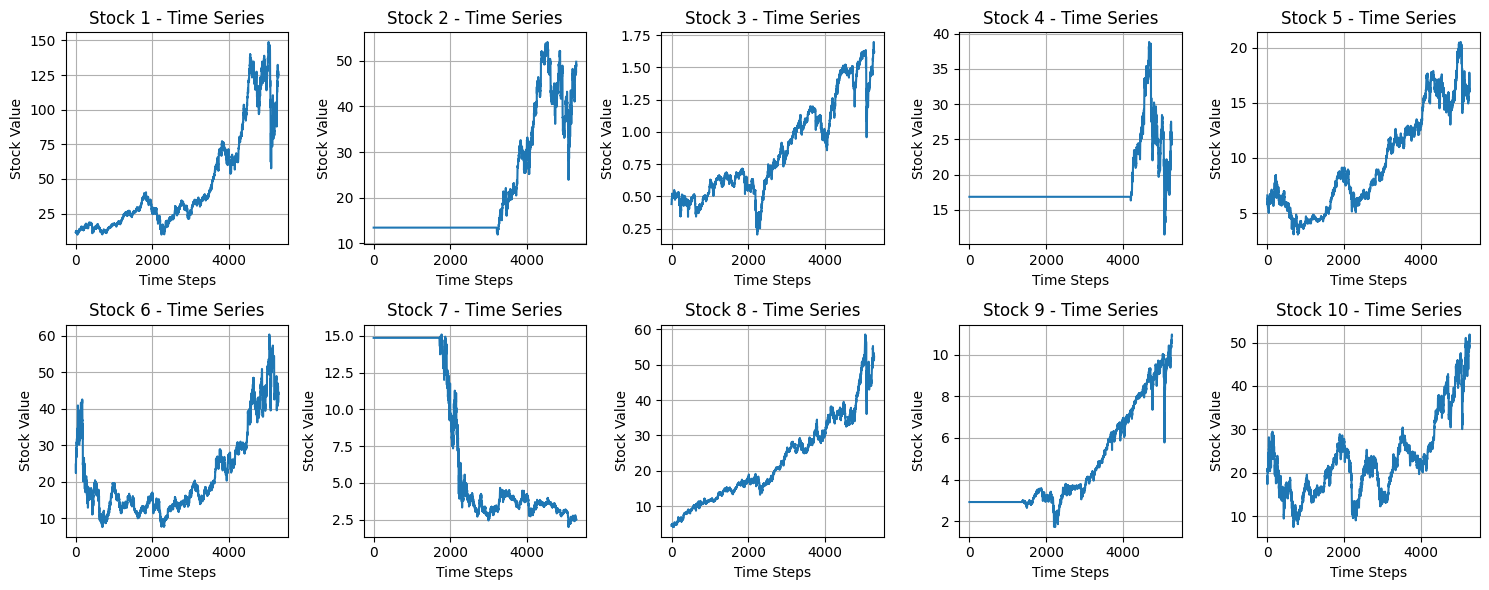

In [4]:

# Plotting the first 5 stocks' time-series data
plot_timeseries(data, num_charts=10)

In [5]:
# data = torch.diff(data, dim=1)

data = scale_timeseries_data(data, dim=1)  # Scale each stock independently


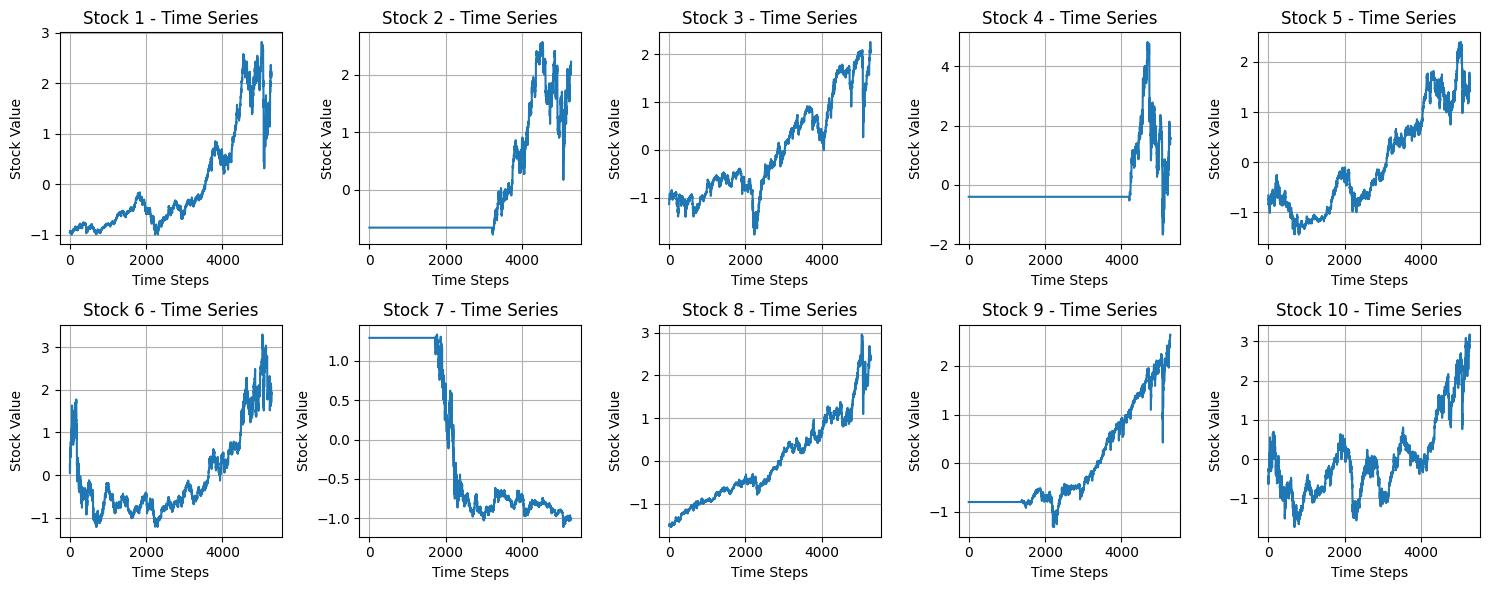

In [6]:
plot_timeseries(data, num_charts=10)

In [7]:
num_of_channels=512*4

pred_ahead=32

clean_data = data[0:num_of_channels].transpose(0, 1)
print(clean_data.shape)
# 

torch.Size([5283, 2048])


In [8]:
inp_clean_data=clean_data.unfold(dimension=0, size=pred_ahead, step=1)

In [9]:
inp_clean_data=inp_clean_data.reshape(inp_clean_data.shape[0],-1)

In [10]:
outp_clean_data = inp_clean_data[pred_ahead:,:]
inp_clean_data = inp_clean_data[:-pred_ahead,:]

In [11]:
config = TransformerConfig(
    precision=torch.float32,
    batch_size=256,
    block_size=1,
    causal=True,
    input_embed=pred_ahead*num_of_channels,
    n_embed=256,
    output_embed=pred_ahead*num_of_channels,
    n_head=8,
    n_layer=8,
    learning_rate=1e-4,
    shift_output=0,
    my_device=my_device
)
config.eval_interval=500
config.save_model_periodically_every_n_iterations = -1

trainer1 = GenericModelRunner(
    config, 
    TorchTransformerModel(config), 
    GenericDataloader(config, inp_clean_data, outp_clean_data)
) 

# trainer1.load_model('abc')

trainer1.train_iterate_n(100000)

# trainer1.save_model('abc')

Using device: mps
141.107456 M parameters
step 0: rmse train loss 0.8271, rmse val loss 1.9666, sec/iter 3.814697265625e-09
step 500: rmse train loss 0.3069, rmse val loss 3.7342, sec/iter 0.07596023225784301
step 1000: rmse train loss 0.2876, rmse val loss 3.7283, sec/iter 0.07872060155868531
step 1500: rmse train loss 0.2781, rmse val loss 3.7799, sec/iter 0.07908884572982788


KeyboardInterrupt: 

In [ ]:
sh=0

context = inp_clean_data.to(my_device)[sh:1+sh, :]
context = context.reshape((1, context.shape[0], context.shape[1]))
print(context.shape)

out = trainer1.gen(context)

print(out.shape)

inpa = context[0,:,0:pred_ahead]
outpa = out[0,:,0:pred_ahead]

to_plot = torch.cat([inpa, outpa], dim=1)
plot_timeseries(to_plot, num_charts=1)

In [ ]:
for i in range(0, 1):
    sh = 10 * i
    stock = 40

    stock_shift = stock * pred_ahead
    
    context = inp_clean_data.to(my_device)[sh:1+sh, :]
    context = context.reshape((1, context.shape[0], context.shape[1]))
    print(context.shape)
    
    out = trainer1.gen(context)
    
    print(out.shape)
    
    inpa = context[0,:,0 + stock_shift:pred_ahead + stock_shift]
    plot_timeseries(inpa, num_charts=1)
    
    outpa = out[0,:,0 + stock_shift:pred_ahead + stock_shift]
    plot_timeseries(outpa, num_charts=1)
    
    to_plot = torch.cat([inpa, outpa], dim=1)
    plot_timeseries(to_plot, num_charts=1)